# Libraries

In [2]:
import numpy as np
import pandas as pd

# Data

In [3]:
path = './data/'
filename = 'processed_data_v01.csv'

df = pd.read_csv(path + filename, converters={'Tags': pd.eval})
df.set_index('Id', inplace=True)

tag_list = [tag[4:] for tag in list(df.columns) if 'tag' in tag]

In [5]:
df.head()

,processed_text,text,Title,Body,Score,ViewCount,AnswerCount,Tags,tag_c#,tag_java,tag_javascript,tag_python,tag_c++,tag_ios,tag_android,tag_.net,tag_html,tag_php
Id,,,,,,,,,,,,,,,,,,
4,decimal c# variable opacity app error type,How to convert Decimal to Double in C#? <p>I w...,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot...,792,70052,14,[c#],1,0,0,0,0,0,0,0,0,0
11,time c# value time,Calculate relative time in C# <p>Given a speci...,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,1644,196587,41,[c#],1,0,0,0,0,0,0,0,0,0
13,user timezone way web server user timezone web...,Determine a user's timezone <p>Is there a stan...,Determine a user's timezone,<p>Is there a standard way for a web server to...,698,274233,27,[html],0,0,0,0,0,0,0,0,1,0
25,c socket api c++ z os issue c socket api c++ z...,How to use the C socket API in C++ on z/OS <p>...,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,175,15797,9,[c++],0,0,0,0,1,0,0,0,0,0
109,t sql cast c#/vb.net site resurgence asprox sq...,Decoding T-SQL CAST in C#/VB.NET <p>Recently o...,Decoding T-SQL CAST in C#/VB.NET,<p>Recently our site has been deluged with the...,69,6068,2,[c#],1,0,0,0,0,0,0,0,0,0


In [6]:
df.loc[df.processed_text.isna()]

,processed_text,text,Title,Body,Score,ViewCount,AnswerCount,Tags,tag_c#,tag_java,tag_javascript,tag_python,tag_c++,tag_ios,tag_android,tag_.net,tag_html,tag_php
Id,,,,,,,,,,,,,,,,,,
14269587,NaN,How to execute <script> code in a javascript a...,How to execute <script> code in a javascript a...,<p>I'm working with a plugin that is only Java...,15,30125,6,"[javascript, html]",0,0,1,0,0,0,0,0,1,0


In [7]:
df.drop(index=14269587, inplace=True)

# Bag of words

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate the vectorizer
cv = CountVectorizer(max_df=0.8,
                     min_df=0.001
                     )

# Vectorize the processed text
X = cv.fit_transform(df.processed_text)

In [9]:
X.shape

(31928, 1973)

In [10]:
len(cv.get_feature_names_out())

1973

In [11]:
cv.get_feature_names_out()[:50]

array(['abc', 'ability', 'abstraction', 'access', 'accessing', 'account',
       'accuracy', 'action', 'active', 'activity', 'ad', 'adapter', 'add',
       'addition', 'address', 'admin', 'administrator', 'ado', 'adobe',
       'advance', 'advantage', 'advice', 'aes', 'afaik', 'afnetworking',
       'age', 'agent', 'aim', 'air', 'ajax', 'alert', 'algorithm', 'alia',
       'alias', 'alignment', 'allocation', 'allocator', 'allow', 'alpha',
       'alternative', 'amazon', 'ambiguity', 'amd', 'amount', 'anaconda',
       'analysis', 'analytics', 'anchor', 'and', 'android'], dtype=object)

In [12]:
X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [13]:
X[0].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]])

Modelisation, multi output

In [14]:
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

In [15]:
y

,tag_c#,tag_java,tag_javascript,tag_python,tag_c++,tag_ios,tag_android,tag_.net,tag_html,tag_php
Id,,,,,,,,,,
4,1,0,0,0,0,0,0,0,0,0
11,1,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,1,0
25,0,0,0,0,1,0,0,0,0,0
109,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
75115453,0,0,0,1,0,0,0,0,0,0
75120349,0,1,0,0,0,0,0,0,0,0
75128330,0,0,1,1,0,0,0,0,0,0


In [16]:
from sklearn.model_selection import train_test_split



In [84]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import time

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=5
)

forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest)

start = time.time()
multi_target_forest.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

start = time.time()
y_pred_train = multi_target_forest.predict(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test = multi_target_forest.predict(X_test)


fit time: 122.61611843109131 secs.
predict time: 7.727133274078369 secs.


In [51]:
def classif_report_per_tag(tag_list,y_test,y_pred):
    
    reports = {}

    for idx,tag in enumerate(tag_list):
        reports[tag] = classification_report(
            y_test.values[:,idx], 
            y_pred[:,idx], 
            target_names=[tag, f'not_{tag}'],
            output_dict=True)
    
    precision = [reports[rep]['macro avg']['precision'] for rep in reports]
    recall = [reports[rep]['macro avg']['recall'] for rep in reports]
    f1_score = [reports[rep]['macro avg']['f1-score'] for rep in reports]
    accuracy = [reports[rep]['accuracy'] for rep in reports]
    support = [reports[tag][tag]['support'] for tag in tag_list]
    support_not_tag = [reports[tag][f'not_{tag}']['support'] for tag in tag_list]

    report = pd.DataFrame({'tag': tag_list,
                           'precision': precision,
                           'recall' : recall,
                           'f1_score' : f1_score,
                           'accuracy' : accuracy, 
                           'support' : support, 
                           'support_not_tag' : support_not_tag
                           }
                          )

    return report


See scikit-learns's module on [Multiclass and multilabel classification](https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification)

In [52]:
classif_report_per_tag(tag_list,y_train,y_pred_train)

,tag,precision,recall,f1_score,accuracy,support,support_not_tag
0,c#,0.849904,0.752448,0.787820,0.890386,8617,1920
1,java,0.917451,0.848863,0.878246,0.937648,8776,1761
2,javascript,0.894315,0.842770,0.865764,0.935560,8945,1592
3,python,0.962648,0.910692,0.934467,0.970959,9107,1430
4,c++,0.928275,0.773866,0.828703,0.939831,9261,1276
5,ios,0.945541,0.875803,0.906827,0.967258,9414,1123
6,android,0.945567,0.888380,0.914521,0.973142,9563,974
7,.net,0.783170,0.566374,0.592073,0.911075,9535,1002
8,html,0.838452,0.648009,0.699697,0.942773,9792,745
9,php,0.938332,0.870939,0.901417,0.979406,9903,634


In [ ]:
classif_report_per_tag(tag_list,y_test,y_pred_test)

In [82]:
import matplotlib.pyplot as plt

def plot_classif_report_per_tag(classif_report,model_name, dataset):

    plot_data = classif_report

    fig = plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.xticks(plot_data.index+1,plot_data.tag)
    # fig.set_xticklabels(plot_data.tag)
    colors = ['blueviolet', 'deeppink', 'dodgerblue', 'darkorange']

    for metric,color in zip(['precision', 'recall', 'f1_score', 'accuracy'], colors):
        plt.scatter(plot_data.index+1,plot_data[metric],label=metric, c=color)
    plt.legend()
    plt.ylim(0,1.3)
    plt.title(f'Some metrics by tag\nModel: {model_name}, set: {dataset}')
    plt.show()

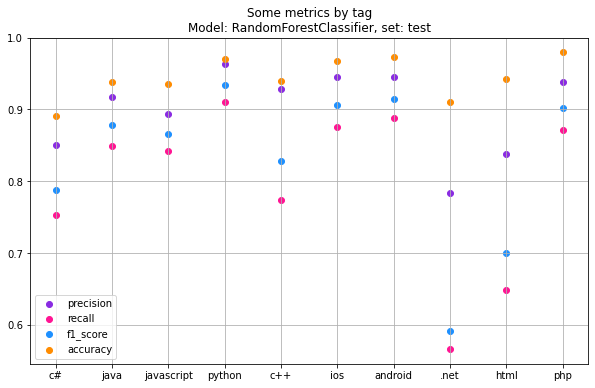

In [73]:
classif_report = classif_report_per_tag(tag_list,y_test,y_pred)
model_name = 'RandomForestClassifier'

plot_classif_report_per_tag(classif_report,model_name,'test')

In [75]:
classif_report

,tag,precision,recall,f1_score,accuracy,support,support_not_tag
0,c#,0.999971,0.999876,0.999923,0.999953,17372,4019
1,java,0.999916,0.999581,0.999749,0.999860,17807,3584
2,javascript,0.999945,0.999679,0.999812,0.999907,18272,3119
3,python,0.999973,0.999838,0.999905,0.999953,18299,3092
4,c++,0.999800,0.999974,0.999887,0.999953,18895,2496
5,ios,1.000000,1.000000,1.000000,1.000000,19183,2208
6,android,0.999974,0.999741,0.999857,0.999953,19463,1928
7,.net,1.000000,1.000000,1.000000,1.000000,19331,2060
8,html,0.999975,0.999638,0.999807,0.999953,20009,1382
9,php,1.000000,1.000000,1.000000,1.000000,20074,1317


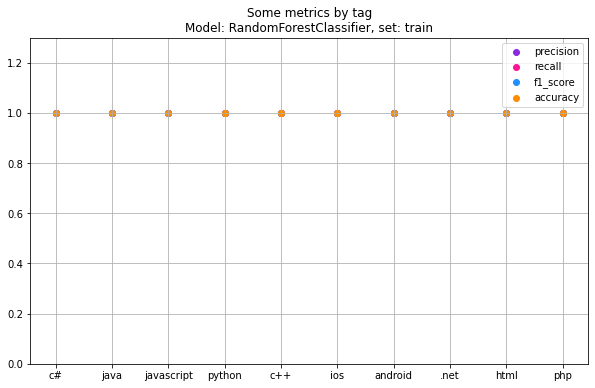

In [83]:
y_pred = multi_target_forest.predict(X_train)
classif_report = classif_report_per_tag(tag_list,y_train,y_pred)
model_name = 'RandomForestClassifier'

plot_classif_report_per_tag(classif_report,model_name,'train')

See scikit-learn's module on [Jaccard similarity coefficient score](https://scikit-learn.org/stable/modules/model_evaluation.html#jaccard-similarity-coefficient-score)

In [54]:
from sklearn.metrics import jaccard_score

jaccard_score(y_test,y_pred, average='samples')

0.6323147005789123

In [55]:
jaccard_score(y_test,y_pred, average='macro')

0.5607022824731206

In [59]:
jaccard_score(y_test,y_pred, average=None)

array([0.47091159, 0.657277  , 0.62465451, 0.79463087, 0.52757079,
       0.71202003, 0.72970392, 0.13079777, 0.27349398, 0.68596237])

In [137]:
classif_rep_c = classification_report(
    y_test.values[:,0], 
    multi_target_forest.predict(X_test)[:,0], 
    target_names=['c#', 'notc#'],
    output_dict=False)
print(classif_rep_c)

              precision    recall  f1-score   support

          c#       0.90      0.97      0.94      8617
       notc#       0.80      0.54      0.64      1920

    accuracy                           0.89     10537
   macro avg       0.85      0.75      0.79     10537
weighted avg       0.88      0.89      0.88     10537



In [126]:
multi_target_forest.score(X_train,y_train)

0.99962601093918

In [128]:
multi_target_forest.score(X_test,y_test)

0.5636329125937174